# AVISO data assimilation with correlated error reduction with 1-step approach

In [1]:
import numpy as np
import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
from scipy import linalg
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from tqdm import tqdm
from aviso_rossby_wave import skill_matrix, inversion
from aviso_rossby_wave import build_swath, make_error
from aviso_rossby_wave import reverse_vector, forecast_ssh

## Starting Date

In [2]:
day0, day1 = 0, 1 # April 1st, 2017 # day0, day1 =  1856, 1857 July 1st, 2017
start_date = '2016-06-01' ## starting date
n_waves = '450' #number of waves

## Subset 10 degree by 10 degree of ocean

In [3]:
lonidx_west, lonidx_east  =  60, 100
latidx_south, latidx_north = 34, 74

In [4]:
avisso_ds = xr.open_dataset('./aviso_msla_ccs_5d.nc')
SSHA = avisso_ds.msla[latidx_south:latidx_north,lonidx_west:lonidx_east,  :]

In [5]:
T_time = avisso_ds.time.data[day0:] * 86400 # time in seconds
date_time = avisso_ds.date_time.data[day0:]
date_time[0], avisso_ds.msla.shape, SSHA.shape # longtitude, latitude, time

(numpy.datetime64('2016-06-01T00:00:00.000000000'),
 (104, 184, 150),
 (40, 40, 150))

In [6]:
ssha_time_mean = SSHA.mean(axis = -1)

In [7]:
SSHA = SSHA - SSHA.mean(axis = -1) - SSHA.mean(axis = 0)

In [8]:
SSHA_masked = np.ma.masked_invalid(SSHA)

In [9]:
ssha_mask = np.ma.getmask(SSHA_masked)

In [10]:
lon, lat = (360 - avisso_ds.lon[lonidx_west:lonidx_east].data) * -1, avisso_ds.lat[latidx_south:latidx_north].data

### Stratification paramters

In [11]:
Phi0 = lat.mean() # central latitude (φ0)
Omega = 7.27e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 / 1e5 # meters to degrees
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
f0 = 2 * Omega * np.sin(Phi0) #1.0313e-4 # 45 N
g = 9.81 # gravity 

### Inversion with selecetd swath data points

In [12]:
strat_ds = xr.open_dataset('./stratification_sample_ccs.nc')

In [13]:
Psi = strat_ds.Psi.data
MModes = 1
wavespeed = strat_ds.C2[:MModes].data  #np.array([Rm * f0])


### the aviso data is sampled at 5-day intervals

#### Rossby wave estimate

In [14]:
wave_ds = xr.open_dataset('./rossby_wave_estimate_' + start_date +'_' + n_waves + 'waves.nc')

#### Rossby deformation radius

In [15]:
k_n_orig, l_n_orig = wave_ds.k_n.data, wave_ds.l_n.data
amp = wave_ds.Amplitudes.data
time= wave_ds.time.data
MSLA_fwd = wave_ds.MSLA_forward.data
Rm = wave_ds.Rm.data

In [16]:
k_n = k_n_orig.reshape(len(k_n_orig), MModes)
l_n = l_n_orig.reshape(len(l_n_orig), MModes)

In [17]:
MSLA0 = MSLA_fwd[:, :, day0:day1]

In [18]:
skill, SSHA_vector, Iindex, Jindex, Tindex = skill_matrix(MSLA0, Psi, k_n, l_n, MModes, Rm, lon, lat, T_time)
M = skill.size

100%|████████████████████████████████████| 450/450 [00:01<00:00, 248.61it/s]


In [19]:
kk, ll = np.meshgrid(k_n, l_n)

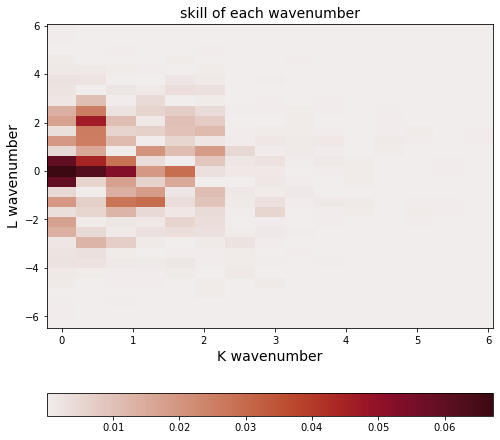

In [20]:
plt.figure(figsize = (8, 8))
plt.pcolor(kk, ll, skill[:, :, 0], cmap = cmo.cm.amp)
plt.xlabel('K wavenumber', fontsize = 14)
plt.ylabel('L wavenumber', fontsize = 14)
plt.colorbar(orientation = 'horizontal')
plt.title('skill of each wavenumber', fontsize = 14)
plt.savefig('./skill_matrix_KLwaves_' + str(M) + '.png')

#### Build basis function H matrix

In [21]:
MModes = 1
H_cos, H_sin = np.zeros([len(SSHA_vector), M]), np.zeros([len(SSHA_vector), M])
H_all = np.zeros([len(SSHA_vector), M * 2])
freq_n = np.zeros([M, MModes])

dlon = lon - lon.mean()
dlat = lat - lat.mean()

count = 0 
for kk in range(len(k_n)):
    for ll in range(len(l_n)):
        for mm in range(MModes):
            freq_n[count, mm] =  -1 * (Beta * k_n[kk]) / (k_n[kk] ** 2 + l_n[ll] ** 2 + Rm ** (-2))
            count += 1
nn = 0 
for kk in range(len(k_n)):
    for ll in range(len(l_n)):
        for mm in range(MModes):
            for count in range(len(Iindex)):
                H_cos[count, nn] = Psi[0, mm] * np.cos(l_n[ll] * dlon[int(Iindex[count])] + k_n[kk] * dlat[int(Jindex[count])] + freq_n[nn] * T_time[int(Tindex[count])])  
                H_sin[count, nn] = Psi[0, mm] * np.sin(l_n[ll] * dlon[int(Iindex[count])] + k_n[kk] * dlat[int(Jindex[count])] + freq_n[nn] * T_time[int(Tindex[count])])
            nn += 1

In [22]:
H_all[:, 0::2] = H_cos 
H_all[:, 1::2] = H_sin

#### build satellite swath

In [23]:
swath_width, x_swath = 6, 20
day = np.arange(day0, day1) # np.array([0, 1]) #range(day0, day1)
xvalid_index, yvalid_index, tindex, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right = build_swath(swath_width, x_swath, day, lon, lat)

#### Add errors to the swaths

In [24]:
alpha_base = 1e-2 # baseline dialation error parameter
alpha_roll = .5e-2 #  np.arange(1, len(day)) # roll error parameter
alpha_timing = .5e-2 # timing error parameter
alpha_phase3, alpha_phase4, alpha_phase5, alpha_phase6 = 4e-2, 3e-2, 2e-2, 1e-2
alpha = np.array([alpha_timing,  alpha_roll, alpha_base, alpha_phase3, alpha_phase4, alpha_phase5, alpha_phase6])
timing_err_valid, roll_err_valid, baseline_dilation_err_valid, phase_err_valid, xc1_valid, xc2_valid  = make_error(day, alpha, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right)

#### Add white noise 

In [25]:
IND_TIMING = -7
IND_ROLL = -6
IND_BASELINE = -5
IND_PHASE3, IND_PHASE4, IND_PHASE5, IND_PHASE6 = -4, -3, -2, -1

In [44]:
N = len(xvalid_index)
MSLA_swath = np.zeros(len(xvalid_index))
nx, ny = len(lon), len(lat)
H_v = np.zeros([N, 2 * M + 7]) # M: number of model
IIndex = np.zeros(N) # N: Number of y data
cor_err = np.zeros(N) # Correlated Error N: Number of y data
Y_v = np.zeros(N)
ssh = np.zeros(N)
xc = (swath_width - 1) / 2

for ii in range(len(xvalid_index)):
    IIndex[ii] = nx * yvalid_index[ii] + xvalid_index[ii]
    cor_err[ii] =  timing_err_valid[ii]+ roll_err_valid[ii] + baseline_dilation_err_valid[ii] + phase_err_valid[ii]
    ssh[ii] = MSLA_fwd[yvalid_index[ii], xvalid_index[ii], int(tindex[ii])]
    Y_v[ii] = ssh[ii] + cor_err[ii] #+ np.random.rand(1)/400
    #timing error
    H_v[ii, IND_TIMING] = 1 # alpha[0] * Xc^0, alpha_timing, TIMING ERR, distance from nadir Xc  
    #baseline dialation error
    H_v[ii, IND_BASELINE] = xc1_valid[ii]  # alpha[1] * Xc^1, alpha_base, BASELINE DIALATION ERR, distance from nadir Xc 
    # roll error
    H_v[ii, IND_ROLL] = xc2_valid[ii]  # alpha[2] * Xc^2, alpha_roll, ROLL ERR, distance from nadir Xc
    # phase error
    H_neg = np.heaviside(-1 * xc1_valid[ii], 1) #
    H_pos = np.heaviside(xc1_valid[ii], 1) # 
    H_v[ii, IND_PHASE3] = H_neg                 # alpha_phase3 * np.heaviside(xx - xc, 1)
    H_v[ii, IND_PHASE4] = xc1_valid[ii] * H_neg # alpha_phase4 * Xc * np.heaviside(xx - xc, 1)
    H_v[ii, IND_PHASE5] = H_pos                 # alpha_phase5 * np.heaviside(xx + xc, 1)
    H_v[ii, IND_PHASE6] = xc1_valid[ii] * H_pos # alpha_phase6 * np.heaviside(xx + xc, 1)
    for nn in range(M):
        JIndex = 2 * MModes * nn
        H_v[ii, JIndex] = H_cos[IIndex[ii].astype(int), nn]
        H_v[ii, JIndex + 1] = H_sin[IIndex[ii].astype(int), nn]

### 1-step approach: Solve for amplitudes and errors together

#### signal to noise ratio

In [45]:
counter = 0
exp = 1
alpha_factor = 1e2
kl = np.zeros(2 * M)
P_over_R = np.zeros([2 * M + 7, 2 * M + 7])
P_over_R[IND_TIMING, IND_TIMING] = alpha[IND_TIMING] * alpha_factor #** 2 # timing error
P_over_R[IND_ROLL, IND_ROLL] = alpha[IND_ROLL] *  alpha_factor #** 2 # roll error
P_over_R[IND_BASELINE, IND_BASELINE] = alpha[IND_BASELINE]*  alpha_factor #** 2 # baseline dilation error
P_over_R[IND_PHASE3, IND_PHASE3] = alpha[IND_PHASE3] *  alpha_factor #** 2 # phase error 1
P_over_R[IND_PHASE4, IND_PHASE4] = alpha[IND_PHASE4]*  alpha_factor  #** 2 # phase error 2
P_over_R[IND_PHASE5, IND_PHASE5] = alpha[IND_PHASE5] *  alpha_factor #** 2 # phase error 3
P_over_R[IND_PHASE6, IND_PHASE6] = alpha[IND_PHASE6]*  alpha_factor  #** 2 # phase error 4

for kk in k_n:
    for ll in l_n:
        kl[counter] = np.sqrt(kk ** 2 + ll ** 2) # wavenumber
        P_over_R[2 * counter, 2 * counter] = kl[counter] ** exp
        P_over_R[2 * counter+ 1, 2 * counter + 1] = kl[counter] ** exp
        counter += 1 

In [46]:
alpha[IND_TIMING] 

0.005

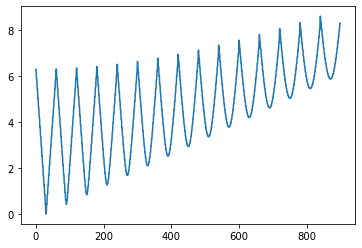

In [47]:
plt.plot(P_over_R.diagonal()[:-7])
#plt.plot(kl)

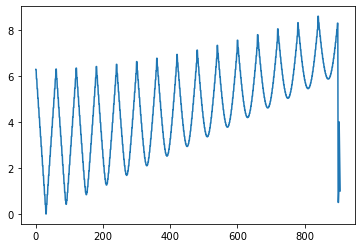

In [30]:
plt.plot(P_over_R.diagonal())

In [31]:
amp_1step, ssh_estimated_swath = inversion(Y_v, H_v, P_over_R)

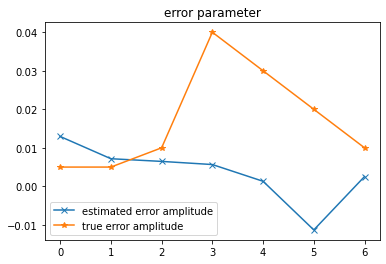

In [32]:
plt.title('error parameter')
plt.plot(amp_1step[-7:], '-x', label = 'estimated error amplitude')
plt.plot(alpha, '-*', label = 'true error amplitude')
plt.legend()

In [33]:
amp_1step[-7:], alpha

(array([ 0.01294366,  0.00716723,  0.00647183,  0.0056566 ,  0.00131078,
        -0.0113132 ,  0.0025395 ]),
 array([0.005, 0.005, 0.01 , 0.04 , 0.03 , 0.02 , 0.01 ]))

In [34]:
for ii in range(len(xvalid_index)):
    IIndex[ii] = nx * yvalid_index[ii] + xvalid_index[ii]
    cor_err[ii] = timing_err_valid[ii]+ roll_err_valid[ii] + baseline_dilation_err_valid[ii] + phase_err_valid[ii]
    ssh[ii] = MSLA_fwd[yvalid_index[ii], xvalid_index[ii], int(tindex[ii])]
    Y_v[ii] = ssh[ii] + cor_err[ii] #+ np.random.rand(1)/400
    H_v[ii, IND_TIMING] = 1 
    H_v[ii, IND_BASELINE] = xc1_valid[ii] 
    H_v[ii, IND_ROLL] = xc2_valid[ii] 
    H_neg = np.heaviside(xc1_valid[ii], 1) 
    H_pos = np.heaviside(xc1_valid[ii], 1) 
    H_v[ii, IND_PHASE3] = H_neg                 
    H_v[ii, IND_PHASE4] = xc1_valid[ii] * H_neg 
    H_v[ii, IND_PHASE5] = H_pos                 
    H_v[ii, IND_PHASE6] = xc1_valid[ii] * H_pos 
    for nn in range(M):
        JIndex = 2 * MModes * nn
        H_v[ii, JIndex] = H_cos[IIndex[ii].astype(int), nn]
        H_v[ii, JIndex + 1] = H_sin[IIndex[ii].astype(int), nn]

ssh_estimated_swath = np.matmul(H_v, amp_1step) # estimated swath SSH

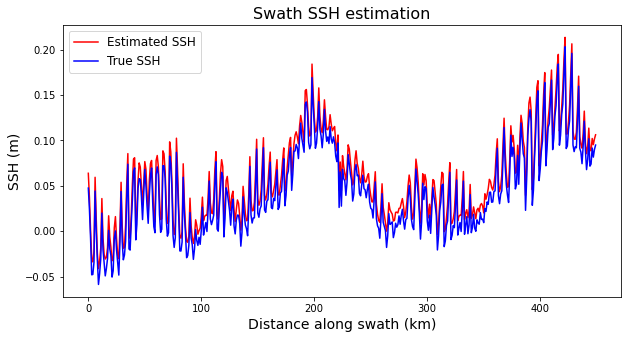

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(ssh_estimated_swath, 'r', label='Estimated SSH')
plt.plot(Y_v, 'b', label='True SSH')
plt.xlabel('Distance along swath (km)', fontsize=14)
plt.ylabel('SSH (m)', fontsize=14)
plt.title('Swath SSH estimation', fontsize=16)
plt.legend(fontsize=12)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


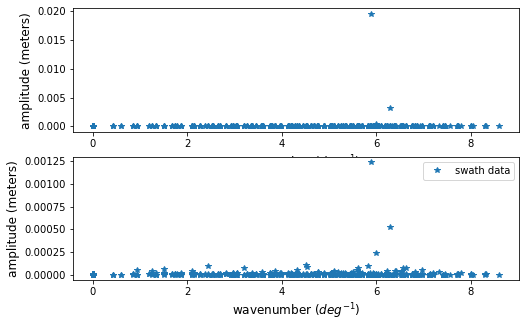

In [36]:
plt.figure(figsize = (8, 5))
plt.subplot(211)
plt.xlabel('wavenumber ($deg^{-1}$)', fontsize = 12)
plt.ylabel('amplitude (meters)', fontsize = 12)
plt.plot(kl, amp_1step[:-7] ** 2  , '*', label = 'true amp')
plt.subplot(212)
plt.legend()

plt.xlabel('wavenumber ($deg^{-1}$)', fontsize = 12)
plt.ylabel('amplitude (meters)', fontsize = 12)
plt.plot(kl, amp ** 2 , '*', label = 'swath data')
plt.legend()

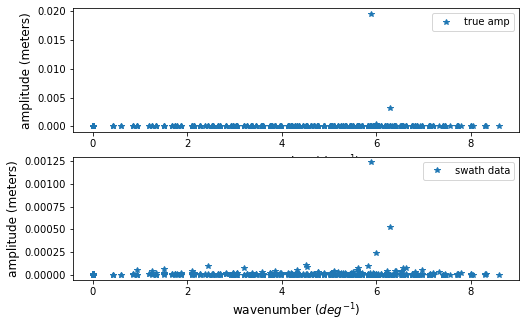

In [37]:
plt.figure(figsize = (8, 5))
plt.subplot(211)
plt.xlabel('wavenumber ($deg^{-1}$)', fontsize = 12)
plt.ylabel('amplitude (meters)', fontsize = 12)
plt.plot(kl, amp_1step[:-7]**2  , '*', label = 'true amp')
plt.legend()

plt.subplot(212)
plt.xlabel('wavenumber ($deg^{-1}$)', fontsize = 12)
plt.ylabel('amplitude (meters)', fontsize = 12)
plt.plot(kl, amp**2 , '*', label = 'swath data')
plt.legend()
#plt.plot(kl, amp, '*') #red spectrum large amp, la

#### True and estimated SSH and Errors

In [38]:
Y_hat = np.matmul(H_v, amp_1step)
err_est = np.matmul(H_v[:, -7:], amp_1step[-7:])
ssh_est = np.matmul(H_v[:, :-7], amp_1step[:-7])
err_map1 = np.zeros([len(lat), len(lon)])
ssh_map1 = np.zeros([len(lat), len(lon)])
ssh_true1 = np.zeros([len(lat), len(lon)])
err_true1 = np.zeros([len(lat), len(lon)])
for ii, idx in enumerate(xvalid_index):
    err_map1[yvalid_index[ii], xvalid_index[ii]] = err_est[ii] #[Iindex[ii].astype(int)]
    ssh_map1[yvalid_index[ii], xvalid_index[ii]]  = ssh_est[ii]
    err_true1[yvalid_index[ii], xvalid_index[ii]] = cor_err[ii]
    ssh_true1[yvalid_index[ii], xvalid_index[ii]] = ssh[ii]

#### Reverse the vectorization on the swaths

In [39]:
ssh_diff1 = np.sqrt(np.mean((ssh_true1 - ssh_map1) ** 2 ))/ np.sqrt(np.mean((ssh_true1) ** 2 ))

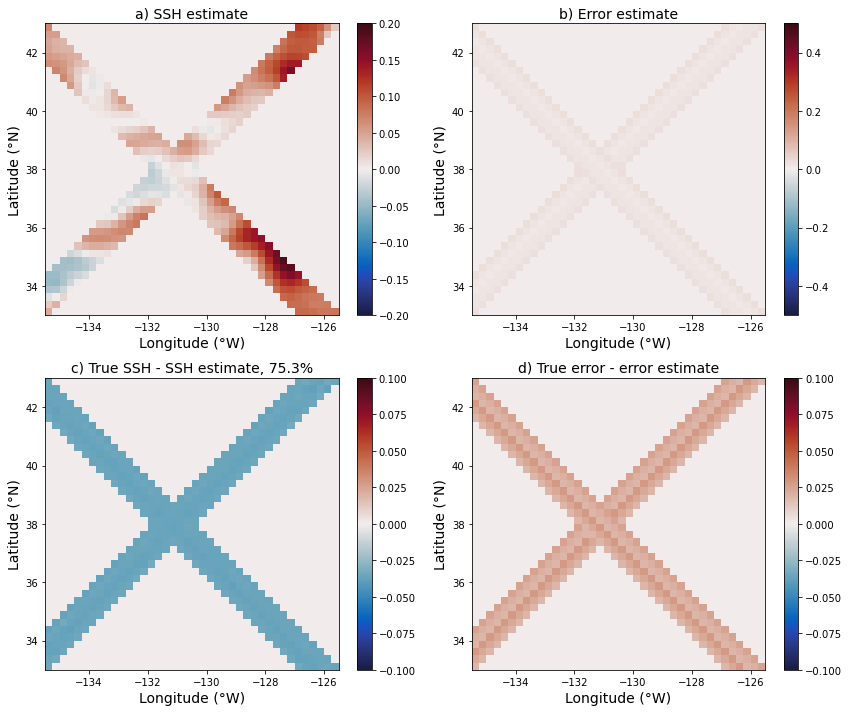

In [40]:
fig = plt.figure(figsize = (12, 10))

plt.subplot(221)
plt.pcolormesh(lon, lat, ssh_map1, vmin = -.2, vmax = .2, cmap = cmo.cm.balance)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('a) SSH estimate', fontsize = 14)

plt.subplot(222)
plt.pcolormesh(lon, lat, err_map1, cmap = cmo.cm.balance, vmin = -.5, vmax = .5)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('b) Error estimate', fontsize = 14)

plt.subplot(223)
plt.pcolormesh(lon, lat, ssh_true1 - ssh_map1, cmap = cmo.cm.balance, vmin = -.1, vmax = .1)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('c) True SSH - SSH estimate, ' + str(ssh_diff1 * 100)[:4] + '%', fontsize = 14)

plt.subplot(224)
plt.pcolormesh(lon, lat, err_true1 - err_map1, cmap = cmo.cm.balance, vmin = -.1, vmax = .1)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('d) True error - error estimate', fontsize = 14)

plt.tight_layout()
plt.savefig('aviso_ssh_estimate_'+ str(date_time[day])[:10] + '_1step.png', dpi = 300)

#### Make predictions of SSH based on the estimated amplitudes:
#### is the extrapolation skill good?

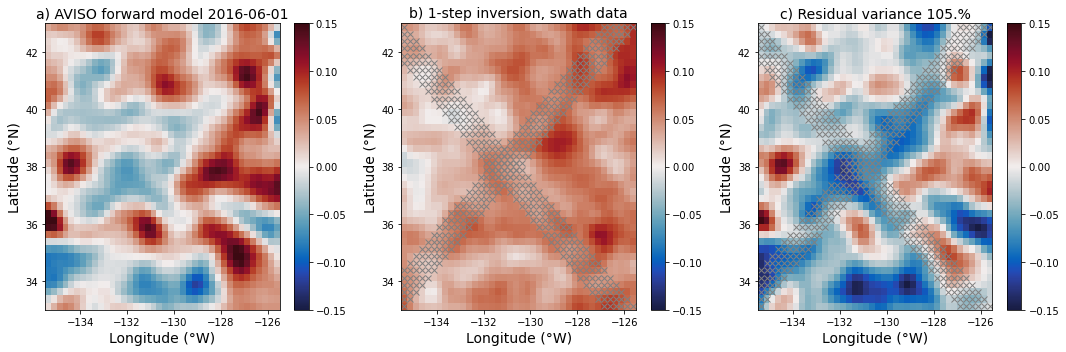

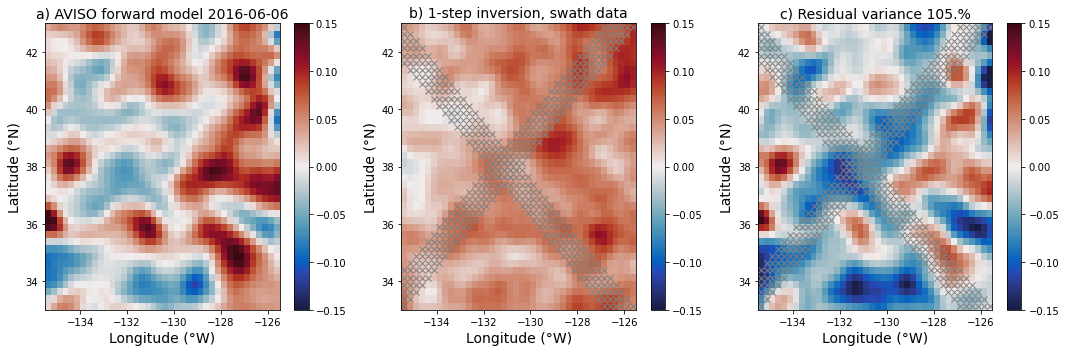

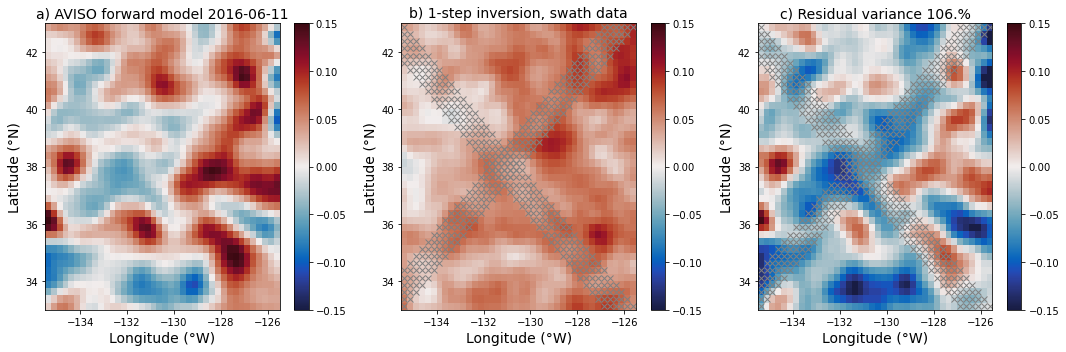

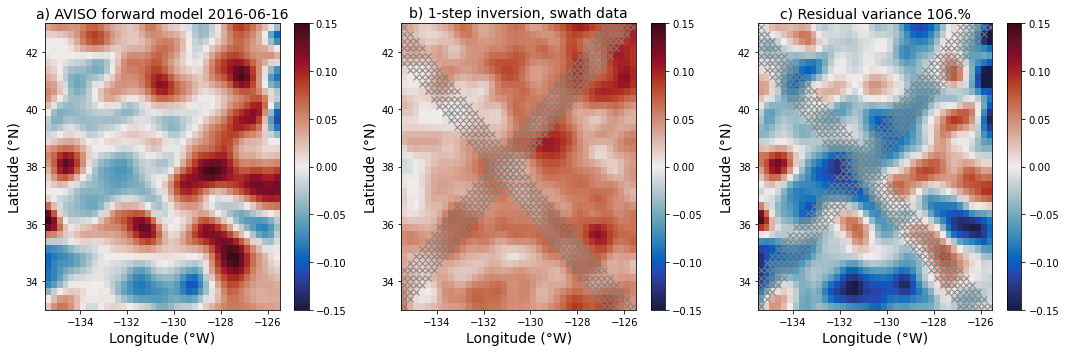

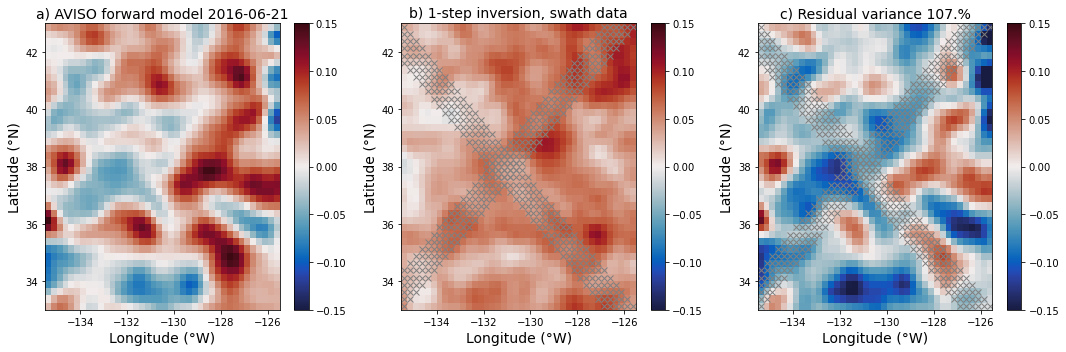

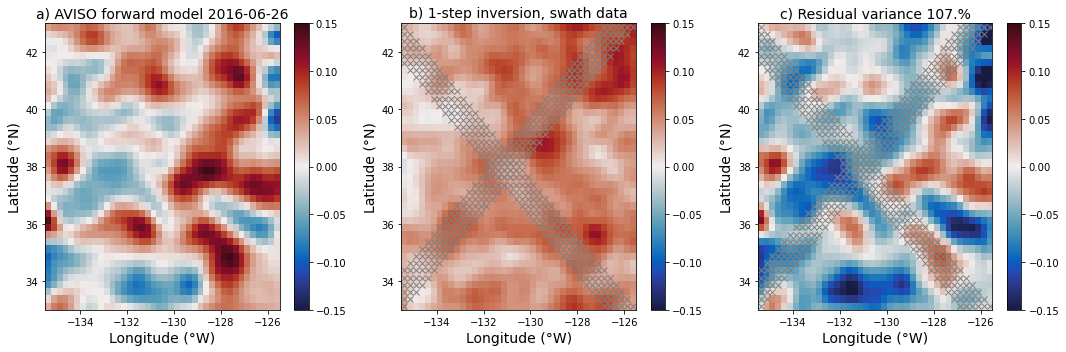

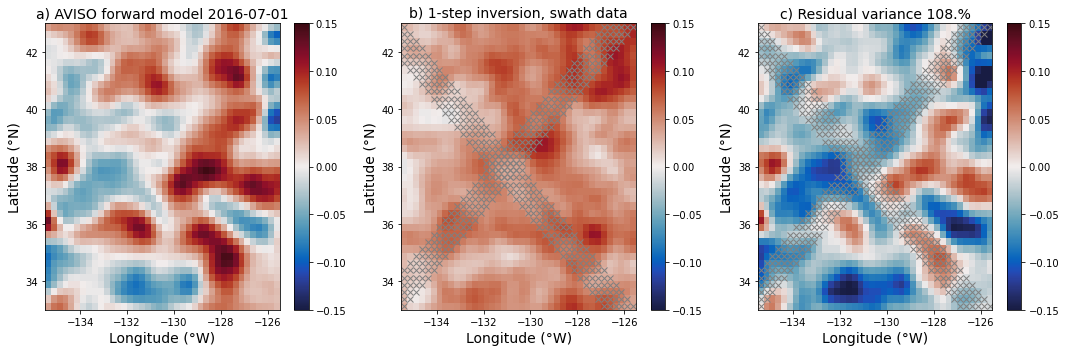

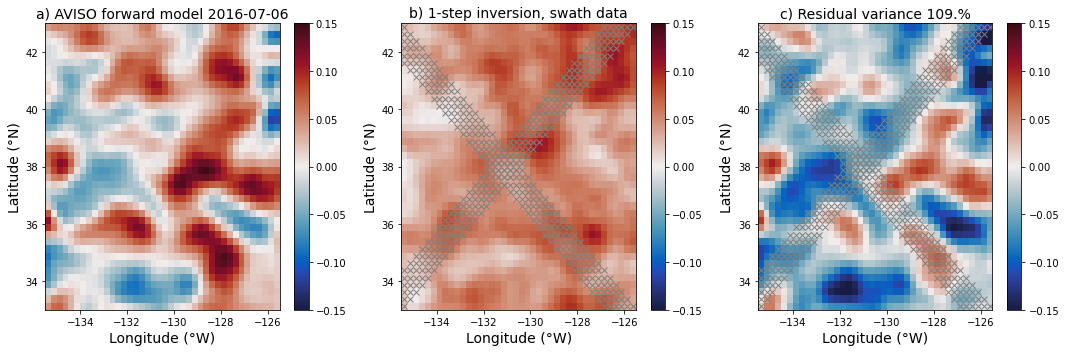

In [41]:
time_range = 8 ## 8 * 5 = 40 days
SSHA_predicted = np.zeros([time_range, MSLA0[:, :, 0:1].size])
SSHA_true = np.zeros([time_range, MSLA0[:, :, 0:1].size])
variance_explained_inverse = np.zeros(time_range)
MSLA_inverse = np.zeros([MSLA0.shape[0], MSLA0.shape[1], time_range])
for day in range(0, time_range):
    MSLA = MSLA_fwd[:,:,day:day+1] 
    SSHA_predicted[day], SSHA_true[day], variance_explained_inverse[day] = forecast_ssh(day, amp_1step[:-7], MSLA, MModes, k_n, l_n, lon, lat, T_time, Psi, Rm)
    MSLA_inverse[:, :, day:day+1] = reverse_vector(MSLA, SSHA_predicted[day])
    
    plt.figure(figsize = (15, 5))

    plt.subplot(131)
    plt.pcolormesh(lon, lat, MSLA[:, :, 0], cmap = cmo.cm.balance, vmin = -.15, vmax = .15) #MSLA_fwd[:, :, day]
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('a) AVISO forward model ' + str(date_time[day])[:10], fontsize = 14)

    plt.subplot(132)
    plt.plot(lon[xvalid_index], lat[yvalid_index], 'x', color = 'gray')
    plt.pcolormesh(lon, lat, MSLA_inverse[:, :, day], vmin = -.15, vmax = .15, cmap = cmo.cm.balance)
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('b) 1-step inversion, swath data', fontsize = 14)

    residual = MSLA[:, :, 0] - MSLA_inverse[:, :, day] 
    plt.subplot(133)
    plt.plot(lon[xvalid_index], lat[yvalid_index], 'x', color = 'gray')
    plt.pcolormesh(lon, lat, residual, cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('c) Residual variance ' + str((1 - variance_explained_inverse[day]) * 100)[:4] + '%', fontsize = 14)
    
    plt.tight_layout()
    #plt.close()
    plt.savefig('ssh_1step_' + str(date_time[day])[:10] +'_2_err_' + str(skill.size) + 'waves.png', dpi = 300)
    

Text(0.5, 1.0, 'residual variance')

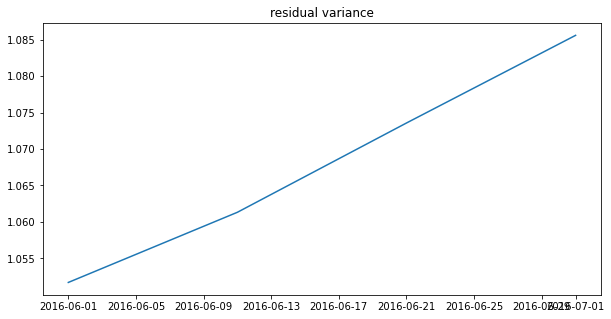

In [42]:
plt.figure(figsize = (10, 5))
plt.plot(time[day0:day0+time_range][0::2], 1-variance_explained_inverse[0::2])
plt.title('residual variance')

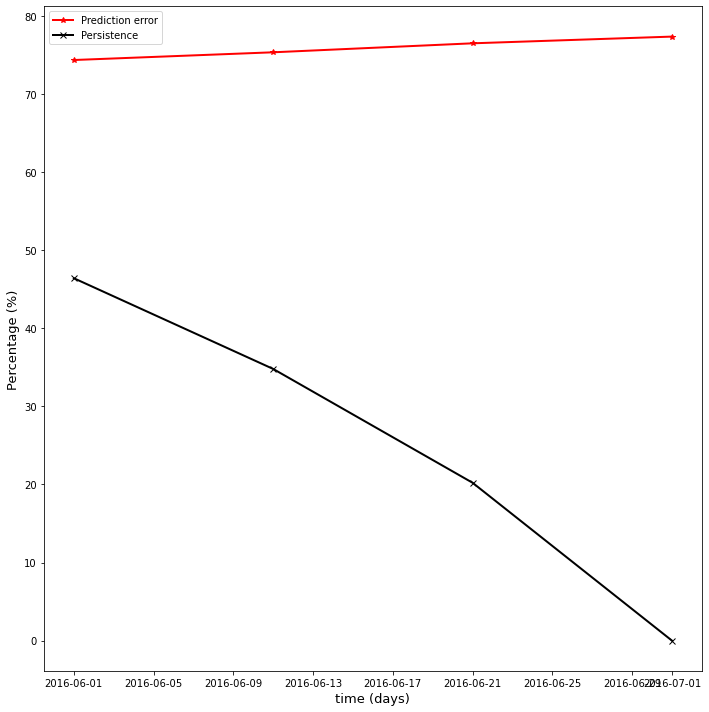

In [43]:
persistence = SSHA.data[:, :, day0:day0+time_range] - SSHA.data[:, :, day0+6:day0+7]
prediction_err = MSLA_inverse[:, :, :time_range] - MSLA_fwd[:, :, :time_range]
rms_persistence = np.zeros(persistence.shape[-1])
rms_prediction_err = np.zeros(prediction_err.shape[-1])
for t in range(persistence.shape[-1]):
    #rms_persistence_err[t] = np.sqrt(np.mean(persistence_err[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, 0:1].data ** 2))
    rms_persistence[t] = np.sqrt(np.mean(persistence[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, 0:1].data ** 2))
    rms_prediction_err[t] = np.sqrt(np.mean(prediction_err[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, t].data ** 2))

plt.figure(figsize = (10,10))
#plt.subplot(211)
plt.plot(time[:time_range][0::2],  rms_prediction_err[:time_range][0::2] * 100,  
         '-*',linewidth = 2, color = 'r', label = 'Prediction error')

#plt.subplot(212)
plt.plot(time[:time_range][0::2], rms_persistence[:time_range][0::2] * 100,  
         '-x', linewidth = 2, color = 'k', label = 'Persistence' )
#plt.plot(T_time[:time_range][0::2]/86400, np.repeat(100, len(time)),linestyle = '--',  color = 'y')
#plt.xticks(time[:time_range][0::2]/86400, time[:time_range][0::2] - time[0])
plt.ylabel('Percentage (%)', fontsize = 13)
plt.xlabel('time (days)', fontsize = 13)
plt.legend()
plt.tight_layout()
plt.savefig('./prediction_vs_persistence/prediction_err_vs_persistence_' + str(M) + '_waves_2errs.png', dpi = 300)